# Fish Passage Model Tool Demo

This notebook demonstrates the functions in the FishPass tool using a dataset for the Chena River in Interior Alaska. The dataset includes a Terrain Works NetMap synthetic stream network, National Hydrography Dataset HUC12 tributaries, and point data representing beaver dams identified via satellite imagery.

#### Import modules

In [1]:
import geopandas as gpd
import pandas
import matplotlib.pyplot as plt
import FishPass

#### Read FishPass tool documentation

The FishPass tool includes documentation for the tool itself and for each individual function. Read the documentation in its entirety by calling the ```help()``` function and passing the module name as an argument.

In [2]:
help(FishPass)

Help on module FishPass:

NAME
    FishPass - A Python Fish Passage Model

DESCRIPTION
    This tool uses three functions to apply a proportional upstream passage model to a stream network with passage restrictions. It is designed to model fish passage over beaver dams, but could potentially be applied to other restrictions.
    
    The stream network must have reaches with unique IDs, and a table that describes the relationship between a given reach and the reach immediately downstream (the "from-to" table). Passage restrictions must reference a reach ID, and reaches can have more than one passage restriction. Stream attributes used to split populations proportionally at confluences must be continuous values and must be available for all reaches in the network. To identify main stem reaches using this tool, the reaches must be grouped by tributaries or other meaningful hydrologic units. Alternatively, main stems can be defined outside of this tool using other stream attributes (eg, s

Alternatively, the help documentation for an individual function can be viewed by passing both the module name and function name as arguments to ```help()```.

In [3]:
help(FishPass.find_main_stems)

Help on function find_main_stems in module FishPass:

find_main_stems(tr, ft)
    Uses a collection of tributaries and the reaches therein to look for any reach within a tributary that flows "from" a reach outside of the tributary; those reaches are marked as being "non-terminal" (ie, the reach continues past the tributary boundary and into another one upstream). All non-terminal reaches are then propagated downstream until the opposite is true (ie, until we find a reach that flows "to" a reach outside of the tributary downstream). All reaches in between these two points are combined into a list of main stem reaches.
    
        If the stream network is not grouped by tributaries or other meaningful hydrologic units, consider defining the main stems list outside of this function using other stream attributes (eg, stream order, stream name) or manually in a GIS. 
    
    Parameters
    ----------
    tr : pandas dataframe, required
        A dataframe with tributary ID in the first co

As the documentation states, we need to create some specific tabular data and lists to use as inputs to the functions. We will start by loading geospatial data and doing some basic joining operations.

#### Load & prep geospatial data 
  
This may take a while depending on size and complexity of the synthetic stream network, as the files must be read to memory.

In [4]:
%cd F:/GIS/OTHER/WS/FishPass_/shp_chena

F:\GIS\OTHER\WS\FishPass_\shp_chena


In [5]:
tribs = gpd.read_file('chena_tribs.shp')
streams = gpd.read_file('chena.shp')
dams = gpd.read_file('Beaver_Points_3338.shp')

Check coordinate reference systems to ensure they are all the same. 

In [6]:
print(tribs.crs)
print(streams.crs)
print(dams.crs)

EPSG:3338
EPSG:3338
EPSG:3338


For this demo, we will remove small streams. Define a stream network with all reaches > order 1.

In [7]:
streams_full = streams[streams['STRM_ORDER'] > 1].copy()

In order to join reaches to the tributaries that contain them, we need to add representative geometry point to each reach line. This is necessary because many reach lines extend past the tributary polygon boundaries, and so an intersection of lines to polygons would produce many duplicate joins (ie, a reach line is joined to two tributaries.)

We want to avoid duplicates in the results, so we will create a representative point for each reach and use that point to join with tributaries.

In [8]:
streams_full['rep_pt'] = streams_full.geometry.representative_point()

#change geometry from polygon to rep point and reassign to new geodataframe
reach_rep = streams_full.set_geometry('rep_pt')

#spatial join rep points to tribs using intersect predicate
#might be unpredictable if stream line is really long and sinuous, but for short NetMap reaches this works fine
trib_reach = gpd.sjoin(tribs, reach_rep, how="left", predicate="intersects") 

To associate dams with stream reaches, we need to join dam points to the stream network using a "nearest" predicate. This join will work even if the dam point is not exactly on the stream line.

In [9]:
reach_dams = gpd.sjoin_nearest(dams, streams_full, how="left") 

#### Format tables for tool input

Now we can reformat our geospatial data to tabular inputs for the FishPass tool. For all functions, the input tables will have a "uID" column for unique reach ID, and the input lists will be lists of uIDs.

The tributary table will be a one-to-many relationship between HUC12 polygons and reach uIDs. We can see that for each HUC12 polygon, there are many stream uIDs.

In [10]:
trib_tbl = trib_reach[['HUC12', 'uID']].copy()
print(trib_tbl)

           HUC12        uID
0   190803071306      chen3
0   190803071306      chen2
0   190803071306      chen1
1   190803060501  chen30395
1   190803060501  chen30394
..           ...        ...
57  190803060404  chen16379
57  190803060404  chen16380
57  190803060404  chen16381
57  190803060404  chen16382
57  190803060404  chen16383

[29417 rows x 2 columns]


Drop any potential NA values from the tributary table to clean up the table for input.

In [11]:
trib_tbl.dropna(inplace=True)

The dam table also allows for one-to-many relationships, as there may be >1 dam per stream reach. NA values and duplicate values in the Dam_Num are OK here, because the script will simply count the number of rows per reach in this table to identify number of beaver dams.

In [12]:
dam_df = reach_dams[['uID', 'Dam_Num']].copy()
print(dam_df)

           uID Dam_Num
0    chen45348      12
1    chen45348       2
2    chen45348       3
3    chen44996       6
4    chen44996       8
..         ...     ...
838    chen773     NaN
838  chen51237     NaN
838  chen29070     NaN
838  chen51097     NaN
838  chen52933     NaN

[849 rows x 2 columns]


The stream attribute table must be a continuous value attribute (such as flow, gradient, width) because it will be used to assign proportions for splitting the fish population as confluences. There must be a value for each reach, or the tool will fail. In this test, we use mean annual flow to assign proportions at confluences.

In [13]:
maf = streams_full[['uID', 'MEANANNCMS']].copy()
print(maf)

             uID  MEANANNCMS
0          chen1      0.5593
1          chen2      0.5593
2          chen3      0.5593
3          chen4      0.5593
4          chen5      0.5593
...          ...         ...
53696  chen53697      0.0587
53697  chen53698      0.0582
53698  chen53699      0.0568
53699  chen53700      0.0563
53700  chen53701      0.0561

[29417 rows x 2 columns]


Use the stream network relationship attributes to define a "from-to" input table.


In [14]:
from_to = streams_full[['uID', 'DOWN_uID']].copy()
print(from_to)

             uID   DOWN_uID
0          chen1      chen0
1          chen2      chen1
2          chen3      chen2
3          chen4      chen3
4          chen5      chen4
...          ...        ...
53696  chen53697  chen53696
53697  chen53698  chen53697
53698  chen53699  chen53698
53699  chen53700  chen53699
53700  chen53701  chen53700

[29417 rows x 2 columns]


#### Demo with plots

First, use the ```find_main_stems``` function with the tributaries table and the "from-to" input table. This will return a list of main stem stream uIDs.

In [15]:
chena_main = FishPass.find_main_stems(trib_tbl, from_to)

Checking inputs...
Processing 58 unique tributaries...
Found 5691 unique main stem reaches.


Next, use the ```find_origins()``` function with the main stem result list and the "from-to" input table. This will return a list of all reaches that flow directly into the main stems, and typically runs much faster than the ```find_main_stems()``` function.

In [16]:
chena_origins = FishPass.find_origins(chena_main, from_to)

Checking inputs...
Found 191 unique origin reaches flowing into main stems.


Plot the main stems and the origins on top of the tributaries and stream network. 

In [17]:
#first subset the original geodataframes using the test trib list, the main stem list, and the origins list
#we will use the reach rep points dataframe for the origins list for clarity in the plot

tribs_gdf = tribs[tribs['HUC12'].isin(trib_tbl['HUC12']).tolist()]
mainstems_gdf = streams_full[streams_full['uID'].isin(chena_main)]
origins_gdf = reach_rep[reach_rep['uID'].isin(chena_origins)]

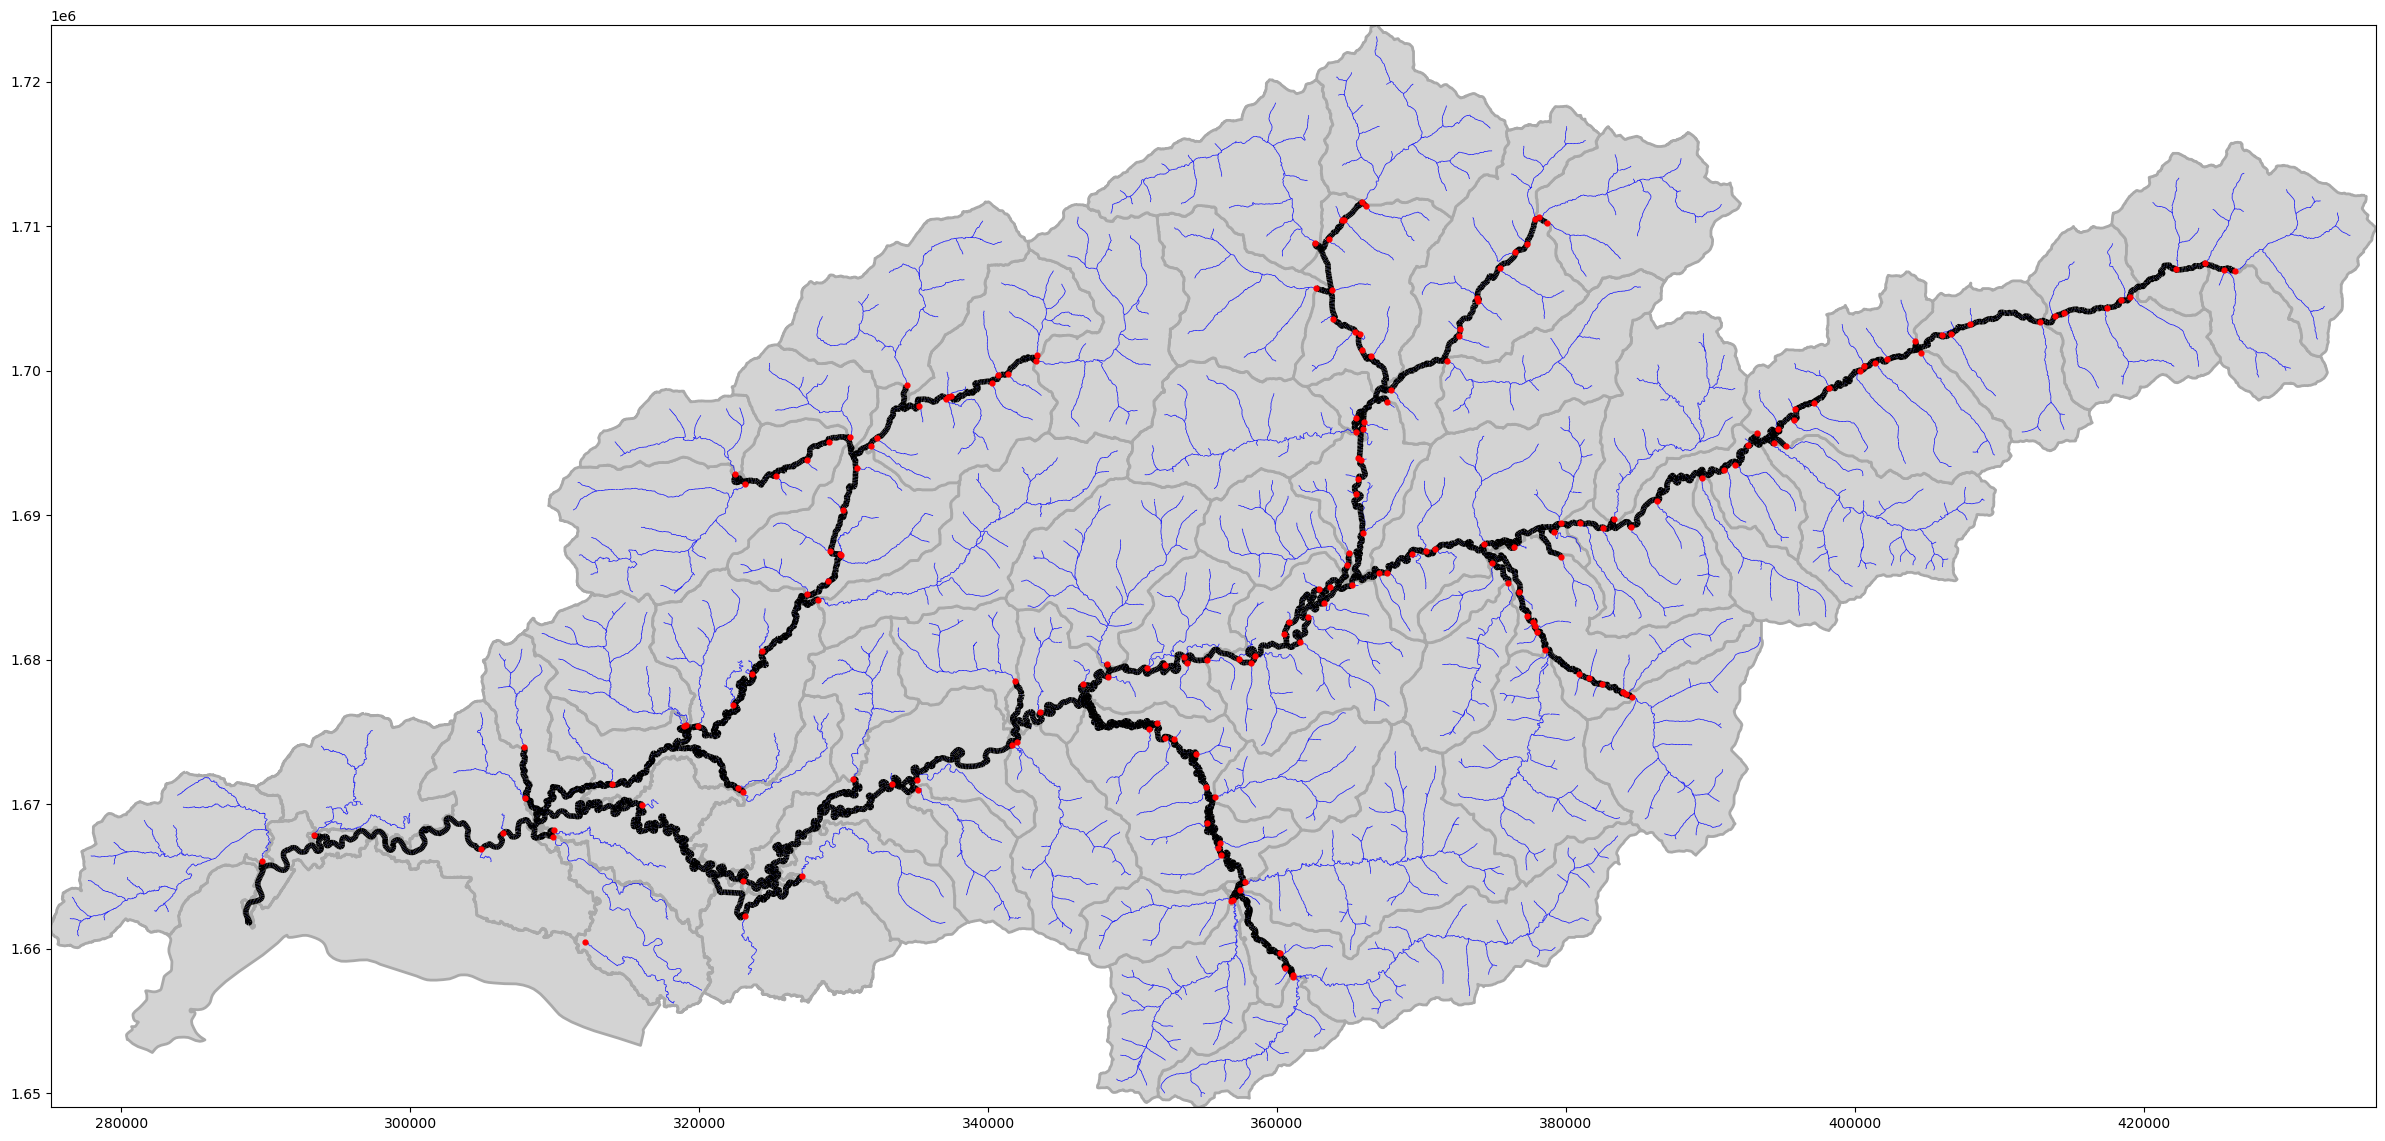

In [18]:
fig, ax = plt.subplots(figsize=(30, 15))

#background tribs and stream network... full network is thin blue lines
tribs_gdf.plot(ax=ax, color='lightgray', edgecolor='darkgray', linewidth = 2, zorder=1)
streams_full.plot(ax=ax, color='blue', linewidth = .5, zorder=2)

#main stems in thick black
mainstems_gdf.plot(ax=ax, color='black', linewidth=4, zorder=3)

#origins in red
origins_gdf.plot(ax=ax, color='red', markersize=12, zorder=10)


#set view extent based on tributary bounds
xlim = ([tribs_gdf.total_bounds[0],  tribs_gdf.total_bounds[2]])
ylim = ([tribs_gdf.total_bounds[1],  tribs_gdf.total_bounds[3]])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

#optionally, save the figure
#plt.savefig('F:/GIS/OTHER/WS/FishPass/mainstems_and_origins_test.jpg')

plt.show();

This map looks correct, so now we can use these results in the fish passage model.

Parameters will be:
- dams table
- origins list
- from-to table for full stream network
- 50% as the percent of population able to pass a dam
- 5% as the percent cutoff to stop travel upstream
- mean annual flow to split population proportionally at confluences

The function will return a list of dataframes, one for each origin in the origins list input. This output provides some flexibility if the user wants to run the model on a large stream network, and then call results from individual tributaries for further analysis.

In [19]:
chena_fishpass = FishPass.fish_passage(dam_df, chena_origins, from_to, 50, 5, maf)

Checking inputs...
Function will use stream attribute MEANANNCMS to split population proportionally at confluences...
Analyzing fish passage upstream of chen10830.......
Analyzing fish passage upstream of chen48440.......
Analyzing fish passage upstream of chen16229.......
Analyzing fish passage upstream of chen9010.......
Analyzing fish passage upstream of chen5074.......
Analyzing fish passage upstream of chen20973.......
Analyzing fish passage upstream of chen35750.......
Analyzing fish passage upstream of chen25358.......
Analyzing fish passage upstream of chen8623.......
Analyzing fish passage upstream of chen37705.......
Analyzing fish passage upstream of chen4399.......
Analyzing fish passage upstream of chen36898.......
Analyzing fish passage upstream of chen27910.......
Analyzing fish passage upstream of chen14511.......
Analyzing fish passage upstream of chen22448.......
Analyzing fish passage upstream of chen6453.......
Analyzing fish passage upstream of chen17180.......
Ana

Checking a few of the results, we see a collection of tables with reach uID in one columns, and percent population passing in the next. The lower range in percent passing is variable with some streams reaching the 5% threshold and some with no restrictions and 100% passing throughout.

In [20]:
chena_fishpass[2:7]

[          uID        pass
 0   chen16229  100.000000
 1   chen16230  100.000000
 2   chen16231   50.000000
 3   chen16232   50.000000
 4   chen16233   50.000000
 5   chen16234   50.000000
 6   chen16235   50.000000
 7   chen16236   25.000000
 8   chen16237   25.000000
 9   chen16238   25.000000
 10  chen16239   25.000000
 11  chen16240   25.000000
 12  chen16241   25.000000
 13  chen16242   25.000000
 14  chen16243   25.000000
 15  chen16244   25.000000
 16  chen16245   25.000000
 17  chen16246   25.000000
 18  chen16247   25.000000
 19  chen16248   25.000000
 20  chen16249   25.000000
 21  chen16250   25.000000
 22  chen16251   25.000000
 23  chen16252   25.000000
 24  chen16253   13.906534
 25  chen16890   11.093466
 26  chen16254   13.906534
 27  chen16891   11.093466
 28  chen16255   13.906534
 29  chen16892   11.093466
 30  chen16256   13.906534
 31  chen16893   11.093466
 32  chen16257   13.906534
 33  chen16894   11.093466
 34  chen16258   13.906534
 35  chen16895   11.093466
 

To plot these, we can concatenate all of the results into one dataframe and join the values to the stream network geodataframe. This will preserve our percent passing results, but add the geometry of the stream network for plotting.

We will leave the origins out of this plot, but include the dams.

In [22]:
df = pandas.concat(chena_fishpass)
chena_fishpass_gdf = df.merge(streams, how='left', on='uID').set_geometry('geometry')

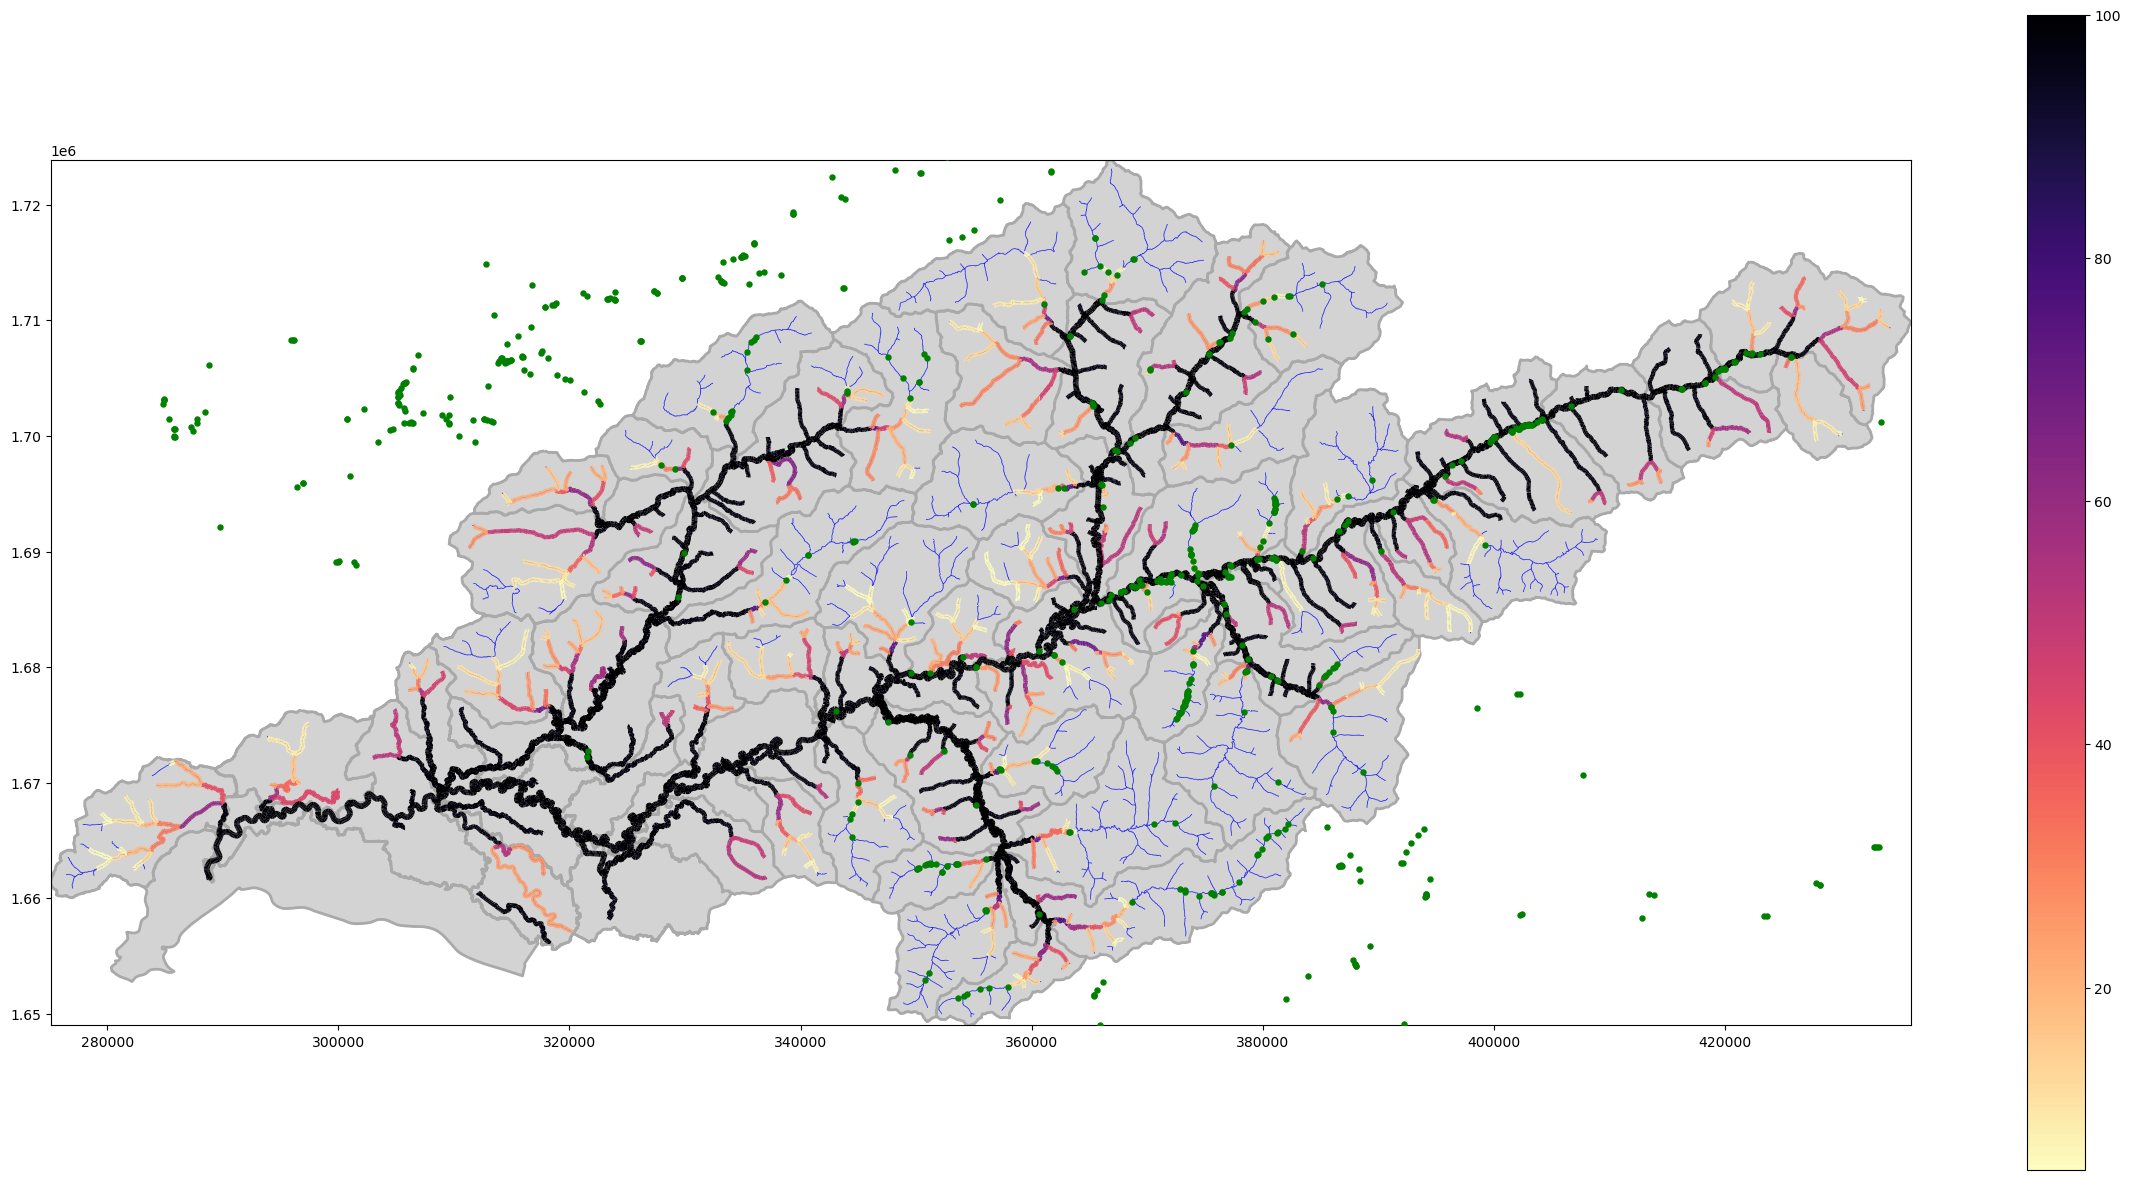

In [26]:
fig, ax = plt.subplots(figsize=(30, 15))

#background tribs and stream network... full network is thin blue lines
tribs_gdf.plot(ax=ax, color='lightgray', edgecolor='darkgray', linewidth = 2, zorder=1)
streams_full.plot(ax=ax, color='blue', linewidth = .5, zorder=2)

#main stems in thick black
mainstems_gdf.plot(ax=ax, color='black', linewidth=4, zorder=3)

#reaches with fish passage, plotted on a color ramp
chena_fishpass_gdf.plot(ax=ax, column='pass', linewidth=3, cmap = 'magma_r', legend=True)

#dams in green dots
dams.plot(ax=ax, color='green', marker='o', markersize=13, zorder=10)


#set view extent based on tributary bounds
xlim = ([tribs_gdf.total_bounds[0],  tribs_gdf.total_bounds[2]])
ylim = ([tribs_gdf.total_bounds[1],  tribs_gdf.total_bounds[3]])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

#optionally, save the figure
#plt.savefig('F:/GIS/OTHER/WS/FishPass/mainstems_and_origins_test.jpg')

plt.show();

Let's zoom in on a particular tributary to see the results more clearly.

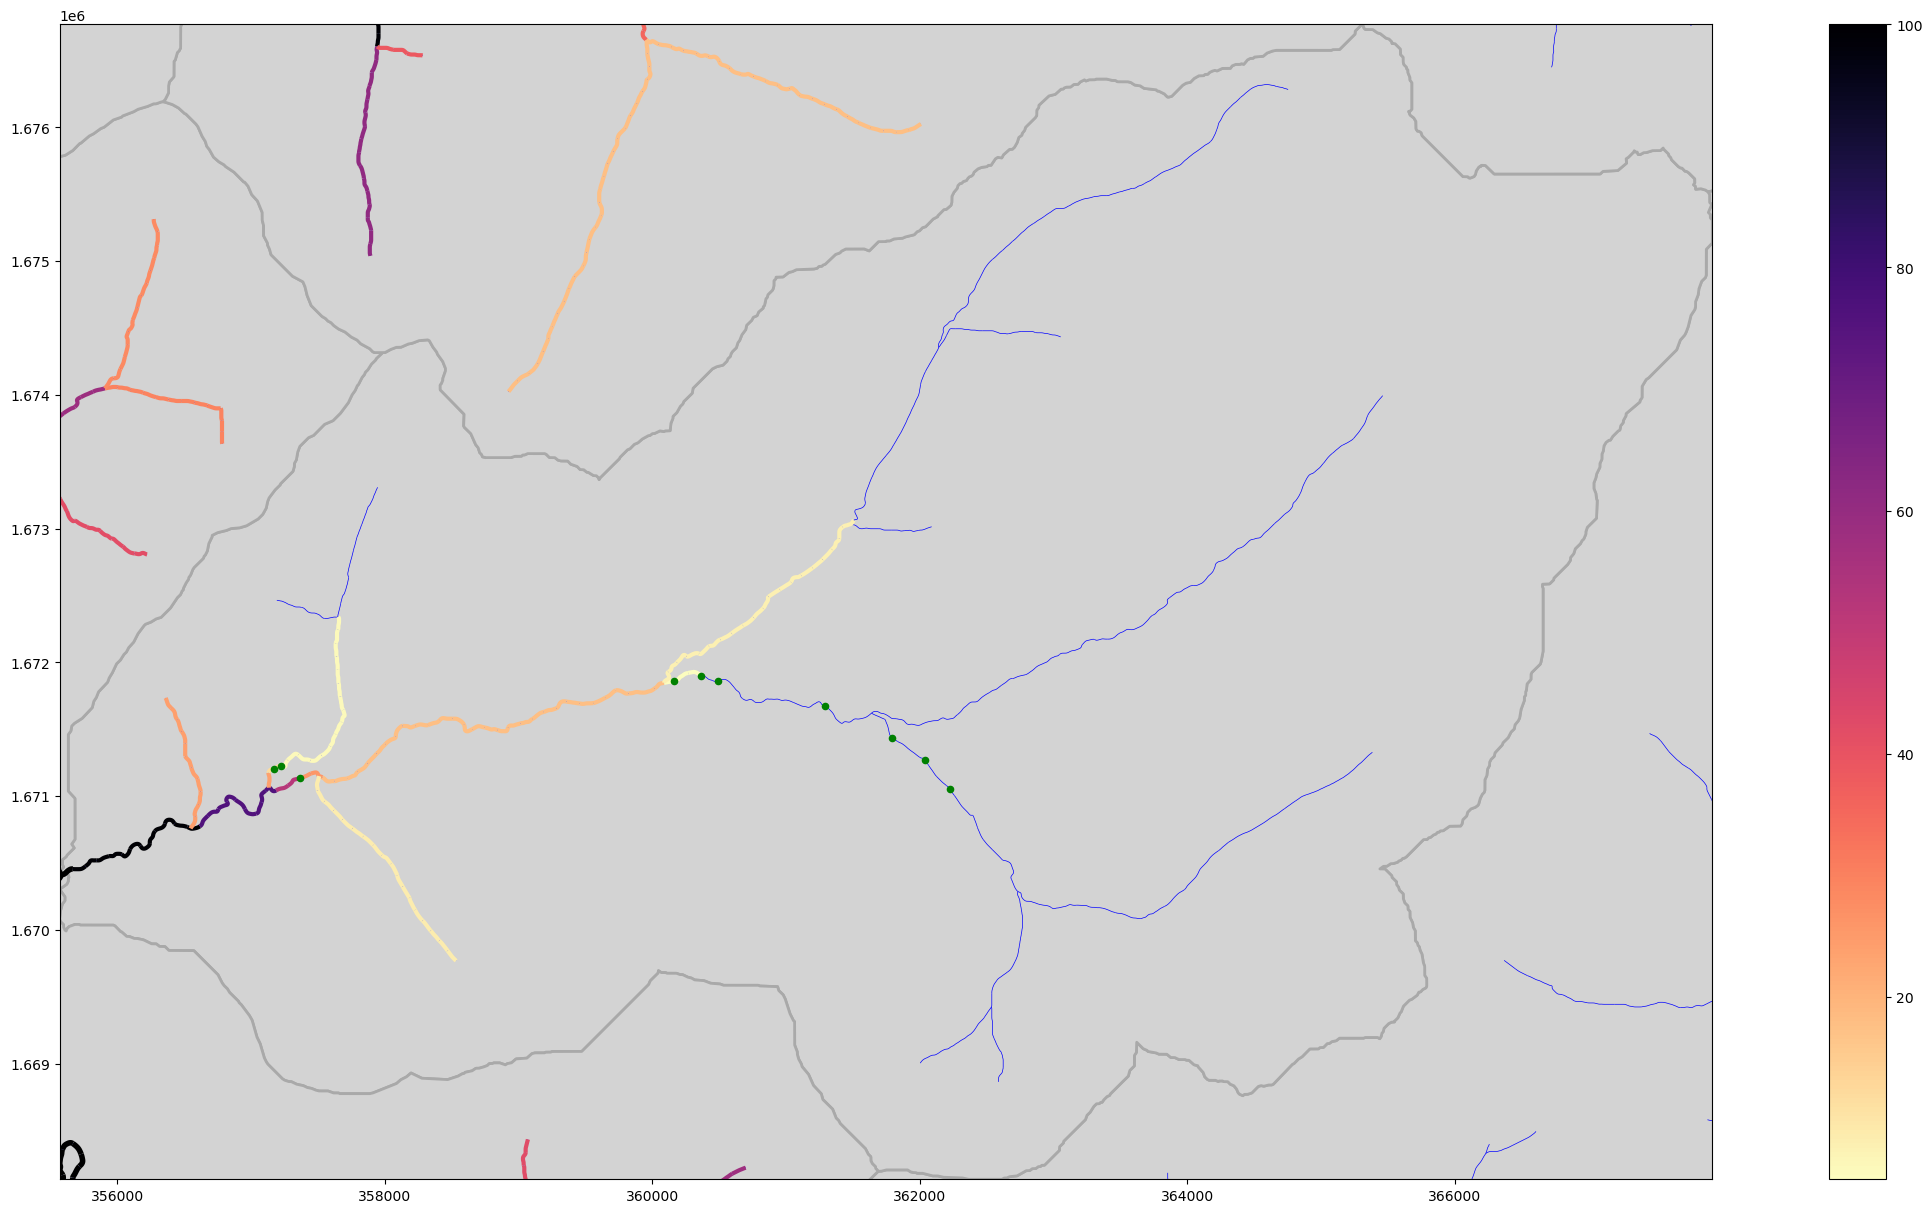

In [60]:
fig, ax = plt.subplots(figsize=(30, 15))

#background tribs and stream network... full network is thin blue lines
tribs_gdf.plot(ax=ax, color='lightgray', edgecolor='darkgray', linewidth = 2, zorder=1)
streams_full.plot(ax=ax, color='blue', linewidth = .5, zorder=2)

#main stems in thick black
mainstems_gdf.plot(ax=ax, color='black', linewidth=4, zorder=3)

#reaches with fish passage, plotted on a color ramp
chena_fishpass_gdf.plot(ax=ax, column='pass', linewidth=3, cmap = 'magma_r', legend=True)

#dams in green dots
dams.plot(ax=ax, color='green', marker='o', markersize=20, zorder=10)


#set view extent based on tributary bounds
#using a particular huc12 index

huc_zoom = 13

xlim = ([tribs_gdf.iloc[[huc_zoom]].total_bounds[0],  tribs_gdf.iloc[[huc_zoom]].total_bounds[2]])
ylim = ([tribs_gdf.iloc[[huc_zoom]].total_bounds[1],  tribs_gdf.iloc[[huc_zoom]].total_bounds[3]])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

#optionally, save the figure
#plt.savefig('F:/GIS/OTHER/WS/FishPass/mainstems_and_origins_test.jpg')

plt.show();

#### Demo with table joins

The functions perform well spatially, and now further analysis can be done by joining these results with stream attributes like length. To perform those analyses we will need to get the total length of the stream networks to make some comparisons.

If we are interested in summarizing results at the tributary level, one way to do that is to simply do a spatial join of tributaries table to the stream network length attribute by uID. We then join the full list of concatenated uIDs to the same table, group by HUC12 and sum the aggregated rows.

In [62]:
trib_length = trib_tbl.merge(streams_full[['uID', 'LENGTH_M']], how='left', on='uID')
trib_length['TOTAL_LENGTH_KM'] = trib_length['LENGTH_M']/1000

pass_length = chena_fishpass_gdf[['uID']].merge(streams_full[['uID', 'LENGTH_M']], how='left', on='uID')
pass_length['PASS_LENGTH_KM'] = pass_length['LENGTH_M']/1000

In [63]:
pass_df = trib_length[['HUC12', 'uID', 'TOTAL_LENGTH_KM']].merge(pass_length[['uID', 'PASS_LENGTH_KM']], how='left', on='uID')

In [64]:
pass_df.groupby('HUC12').sum(numeric_only=True)

,TOTAL_LENGTH_KM,PASS_LENGTH_KM
HUC12,,
190803060101,15.672128,13.983662
190803060102,57.845047,49.504979
190803060103,45.647758,36.242273
190803060104,34.711548,22.187292
190803060105,83.728754,61.351025
190803060201,59.933549,20.370710
190803060202,76.254429,7.111998
190803060203,28.862117,12.797521
190803060204,74.393368,38.362793


The final demonstration is using the ```fish_pass()``` function to define full stream networks at the origin level. Since the ```fish_pass()``` function actually outputs a list of dataframes (one for each origin input), we can also do some analysis for each individual origin. But we will need to know the full length of the stream network upstream from each origin, and not for the tributary at large.

To do this, a special parameter is built into the tool. If we run the same functions again, but use the "NONE" string as stream attribute input, this will not split the population at confluences and will return all uIDs in the stream network upstream of the origin uIDs. To do this, we must also let 100% of fish pass each barrier and use 1% as the cutoff. 

In [65]:
chena_fishpass_none = FishPass.fish_passage(dam_df, chena_origins, from_to, 100, 1, 'NONE')

Checking inputs...
Function will not split population proportionally at confluences...
Analyzing fish passage upstream of chen10830.......
Analyzing fish passage upstream of chen48440.......
Analyzing fish passage upstream of chen16229.......
Analyzing fish passage upstream of chen9010.......
Analyzing fish passage upstream of chen5074.......
Analyzing fish passage upstream of chen20973.......
Analyzing fish passage upstream of chen35750.......
Analyzing fish passage upstream of chen25358.......
Analyzing fish passage upstream of chen8623.......
Analyzing fish passage upstream of chen37705.......
Analyzing fish passage upstream of chen4399.......
Analyzing fish passage upstream of chen36898.......
Analyzing fish passage upstream of chen27910.......
Analyzing fish passage upstream of chen14511.......
Analyzing fish passage upstream of chen22448.......
Analyzing fish passage upstream of chen6453.......
Analyzing fish passage upstream of chen17180.......
Analyzing fish passage upstream of

Since the dataframes are all named after their origin reach uIDs, we can iterate through the origin list and find all appropriate dataframes. Then we run the same length joining process as above, and concatenate the results.

In [66]:
o_lengths_df = pandas.DataFrame(columns=['origin', 'TOTAL_LENGTH_KM', 'PASS_LENGTH_KM'])

for o in chena_origins:
    
    for df in chena_fishpass:
        if df.name == o:
            pass_len = df[['uID']].merge(streams_full[['uID', 'LENGTH_M']], how='left', on='uID')
            pass_len['PASS_LENGTH_KM'] = pass_len['LENGTH_M']/1000  
            
    for df in chena_fishpass_none:
        if df.name == o:
            total_len = df[['uID']].merge(streams_full[['uID', 'LENGTH_M']], how='left', on='uID')
            total_len['TOTAL_LENGTH_KM'] = total_len['LENGTH_M']/1000
        
    if (len(total_len) > 0) & (len(pass_len) > 0):
        
        sum_df = total_len[['uID', 'TOTAL_LENGTH_KM']].merge(pass_len[['uID', 'PASS_LENGTH_KM']], how='left', on='uID')
        
        row = [o]
        
        row.append(sum_df[['TOTAL_LENGTH_KM']].sum()[0])
        row.append(sum_df[['PASS_LENGTH_KM']].sum()[0])
    
        o_lengths_df.loc[len(o_lengths_df)] = row
    

In [67]:
o_lengths_df

,origin,TOTAL_LENGTH_KM,PASS_LENGTH_KM
0,chen10830,1.282966,1.282966
1,chen48440,2.580286,2.580286
2,chen16229,53.818492,6.430603
3,chen9010,48.965149,15.288261
4,chen5074,6.133593,6.133593
...,...,...,...
186,chen45832,18.143126,10.288200
187,chen10297,16.736061,6.778886
188,chen38360,1.004620,1.004620
189,chen10095,12.907956,6.444113


#### Demo of Input Error Testing

Here are some ntentionally produced errors in inputs, to test error catching functionality. This tool does not currently check for errors within the inputs, but only checks to see if the inputs are in the correct format and are non-zero lengths.

In [68]:
# string instead of table
test = FishPass.fish_passage('string input error', chena_origins, from_to, 100, 1, "NONE")

Checking inputs...
Function will not split population proportionally at confluences...


SystemExit: Dams input must be pandas dataframe...check inputs

C:\Users\jdpaul3\Anaconda3\envs\ws_beaver\lib\site-packages\IPython\core\interactiveshell.py:3513: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [69]:
# wrong SA string input
test = FishPass.fish_passage(dam_df, chena_origins, from_to, 100, 1, "NA")

Checking inputs...


SystemExit: Stream attribute input must be string "NONE" or a pandas dataframe...check inputs

In [70]:
# bad number
test = FishPass.fish_passage(dam_df, chena_origins, from_to, 150, 1, maf)

Checking inputs...
Function will use stream attribute MEANANNCMS to split population proportionally at confluences...


SystemExit: Percent passing parameter must be an integer, with possible values of 0 to 100...check inputs

In [71]:
# bad number
test = FishPass.fish_passage(dam_df, chena_origins, from_to, 50, 0, maf)

Checking inputs...
Function will use stream attribute MEANANNCMS to split population proportionally at confluences...


SystemExit: Percent cutoff parameter must be an integer, with possible values of 1 to 100...check inputs

In [72]:
# string instead of table
test = FishPass.find_main_stems('string input error', from_to)

Checking inputs...


SystemExit: Tributaries input must be pandas dataframe...check inputs

In [73]:
# string instead of list
test = FishPass.find_origins('string input error', from_to)

Checking inputs...


SystemExit: Main stem input must be list...check inputs